In this notebook, SentenceTransformer is used to embed recommendation texts into vectors. Then AgglomerativeClustering is used to put similar recommendations into groups.

In [1]:
%pip --trusted-host github.com --trusted-host objects.githubusercontent.com install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.4.0/en_core_web_sm-3.4.0.tar.gz
%git -c http.sslVerify=false clone https://huggingface.co/sentence-transformers/all-mpnet-base-v2

     --------------------------------------- 12.8/12.8 MB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%git` not found.


In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.data_clean_functions import *

In [3]:
import numpy as np
import pandas as pd
import spacy
import re
from sklearn.cluster import AgglomerativeClustering
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sentence_transformers import SentenceTransformer
import pickle
#nlp = spacy.load("en_core_web_sm")

c:\users\vacofredrd.upm.temp\.pyenv\pyenv-win\versions\3.7.9\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# load recommendation lists
recommd = pd.read_csv('CMV_Reports_Article_Recommendations_lists.csv')
recommd['RecommendLists'] = [i.split("&&") for i in recommd['Recommendations']]
print(recommd['RecommendLists'][0][:5])
# print(recommd.head())

['1. establish a separate budget line item for the advisory committee on minonty veterans.', '2. appropriate 125,000.00 for the fiscal year year budget for the advisory committee on minority veterans.', '3. recognize the appropnate regional and national minority organizations that serve our countrys diverse population proups and invite them as genuine partners, consultants, advisors and expert witnesses in enriching the departments commitment to serve the needs of our minomty veterans.', '4. authonze an assessment be conducted and a report submitted in fy 97 by the department of veterans affairs to determine the validity of the commuttees concern regarding ethnic representation on the rating panels and the ment review boards, as well as among the counselors who advise our minority veteran populations.', '5. establish and fund an intra agency task force, chaired by the director of the center for minonty veterans, to conduct a needs assessment for health care, benefits and compensation r

In [5]:
# check the number of recommendations and number of words in total
i = 0
j = 0
for red in recommd['RecommendLists']:
        i = i + len(red)
        for r in red:
#             if len(r.split(" ")) > 1143:
#                 print(r)
            j = j + len(r.split(" "))
        
print(i)
print(j)

259
11926


Use sentence encoders to embed recommendations into vectors. https://www.sbert.net/

In [6]:
# import tensorflow_hub as hub
# from sklearn.manifold import TSNE

# def embbedfn(text):
#     embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
# #     strsent = list(nlp(text).sents)
# #     strsent =  [str(onesentence) for onesentence in strsent if len(onesentence)>10]
#     embeddings = embed(text)
# #     mapped_embeddings = TSNE(n_components=2, metric='cosine', init='pca', verbose = 1).fit_transform(embeddingslocal)
#     return embeddings

def embbedbert(text, model):
    embeddings = model.encode(text)
    return embeddings

model = SentenceTransformer('all-mpnet-base-v2')

In [7]:
# bert sentence encoder
recommd['embeddings'] = recommd.RecommendLists.apply(lambda x: embbedbert(x, model))
recommd['embeddings'][0].shape

(16, 768)

In [8]:
# unlist the nested lists
# previous structure -> [[recommd1 for 1996, recommd2 for 1996, ...], [recommd1 for 1997, recommd2 for 1997, ...],...]
# current structure -> [recommd1 for 1996, recommd2 for 1996, ..., recommd1 for 1997, recommd2 for 1997, ...]
embeddings = []
for i in recommd['embeddings']:
    embeddings.extend(i)
RecommendLists = []
for i in recommd['RecommendLists']:
    RecommendLists.extend(i)
    
print(len(embeddings))
print(len(RecommendLists))

259
259


In [9]:
Years = []
for i in range(len(recommd['RecommendLists'])):
    Years.extend(list(np.repeat(recommd['Year'][i], len(recommd['RecommendLists'][i]))))
print(len(Years))

259


In [10]:
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score
# davies_bouldin_score: ratio of within-cluster distances to between-cluster distances
# clusters which are farther apart and less dispersed will result in a better score.

Start parameter tuning for classification. There are many metrics used here for measuring classification performance. 
1. davies_bouldin_score: ratio of within-cluster distances to between-cluster distances. 
2. silhouette_score: The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.
3. calinski_harabasz_score: It is also known as the Variance Ratio Criterion. Ratio of the sum of between-cluster dispersion and of within-cluster dispersion.

In [11]:
# parameter tunings
# final output is a dataframe that stores all the parameters and their corresponding classification scores

def agg_cluster_tuning(grid):
    output = {'affinity': [],
             'linkage': [],
              'distance_threshold': [],
             'silhouette_score': [],
             'calinski_harabasz_score': [],
             'davies_bouldin_score': [],
             'number_of_clusters': []}
    for aff in grid['affinity']:
        for link in grid['linkage']:
            if link == 'ward' and aff != 'euclidean':
                continue
            clusterer = AgglomerativeClustering(n_clusters=None, affinity=aff, linkage=link, distance_threshold=0.2)
            clusterer.fit_predict(embeddings)
            dist = clusterer.distances_
            minD = min(dist)
            maxD = max(dist)
            step = (max(dist)-min(dist))/10
            for d in np.arange(minD+step, maxD, step):
#                 print(d)
                # fit
                clusterer = AgglomerativeClustering(n_clusters=None, affinity=aff, linkage=link, distance_threshold=d)
                clusters = clusterer.fit_predict(embeddings)
                output['affinity'].append(aff)
                output['linkage'].append(link)
                try:
                    output['silhouette_score'].append(metrics.silhouette_score(embeddings, clusters, metric='euclidean'))
                except:
                    output['silhouette_score'].append(0)
                try:
                    output['calinski_harabasz_score'].append(metrics.calinski_harabasz_score(embeddings, clusters))
                except:
                    output['calinski_harabasz_score'].append(0)
                try:
                    output['davies_bouldin_score'].append(davies_bouldin_score(embeddings, clusters))
                except:
                    output['davies_bouldin_score'].append(0)
                
                output['distance_threshold'].append(d)
                output['number_of_clusters'].append(max(clusters)+1)

    return output
         

In [12]:
grid = {'affinity': ['euclidean', 'manhattan', 'l1', 'l2', 'cosine'],
           'linkage': ['ward', 'complete', 'average', 'single']}
# get the output dataframe 
result = agg_cluster_tuning(grid)
output = pd.DataFrame(result)

In [13]:
import datetime as dt
batch = dt.datetime.now().strftime("%Y%m%d_%H%M%S")
batch 
output['batch'] = batch 
display(output)

,affinity,linkage,distance_threshold,silhouette_score,calinski_harabasz_score,davies_bouldin_score,number_of_clusters,batch
0,euclidean,ward,0.537769,0.082338,7.676754,0.332290,236,20230329_134545
1,euclidean,ward,0.870791,0.130816,3.399469,0.954182,134,20230329_134545
2,euclidean,ward,1.203814,0.081748,4.073481,2.026583,44,20230329_134545
3,euclidean,ward,1.536837,0.049612,4.939887,2.593920,22,20230329_134545
4,euclidean,ward,1.869860,0.022255,5.940200,3.138107,11,20230329_134545
...,...,...,...,...,...,...,...,...
146,cosine,single,0.249629,0.051066,2.363054,0.889759,160,20230329_134545
147,cosine,single,0.295362,-0.025222,1.709113,0.902540,97,20230329_134545
148,cosine,single,0.341096,-0.037909,1.551827,0.865314,51,20230329_134545
149,cosine,single,0.386830,-0.004150,1.669689,0.918561,23,20230329_134545


In [14]:
# save output
with open('recommendation_parameter_tuning', 'wb') as fp:
    pickle.dump(output, fp)
# with open('/dbfs/NAII/CMV Reports/recommendation_parameter_tuning', 'rb') as fp:
#     output = pickle.load(fp)

In [15]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In sum, calinski harabasz score and the number of clusters were used to make the final decision on the values for the parameters. I chose one combination that will have relative good calinski_harabasz_score and reasonable number of clusters. silhouette_score and davies_bouldin_score are used to provide extra informantion on the classification performance.

In [16]:
clusterer = AgglomerativeClustering(n_clusters=None, affinity="euclidean", linkage="ward", distance_threshold = 1.25)
clusters = clusterer.fit_predict(embeddings)

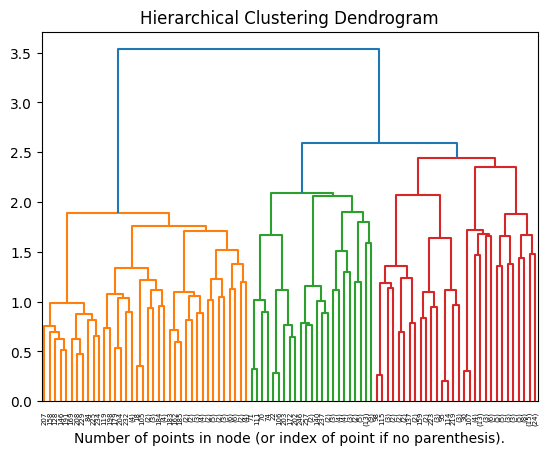

In [17]:
# plot hierarchical clustering dendrogram
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(clusterer, truncate_mode='level', p=6)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [18]:
output.to_csv('CMV_Reports_Article_Recommendations_clusters.csv')

In [19]:
# plot of clusters in 2D
from sklearn.manifold import TSNE
from collections import Counter
df = pd.DataFrame(embeddings)
mapped_embeddings = TSNE(n_components=2, metric='euclidean', init='pca').fit_transform(df)

c:\users\vacofredrd.upm.temp\.pyenv\pyenv-win\versions\3.7.9\lib\site-packages\sklearn\manifold\_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
c:\users\vacofredrd.upm.temp\.pyenv\pyenv-win\versions\3.7.9\lib\site-packages\sklearn\manifold\_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


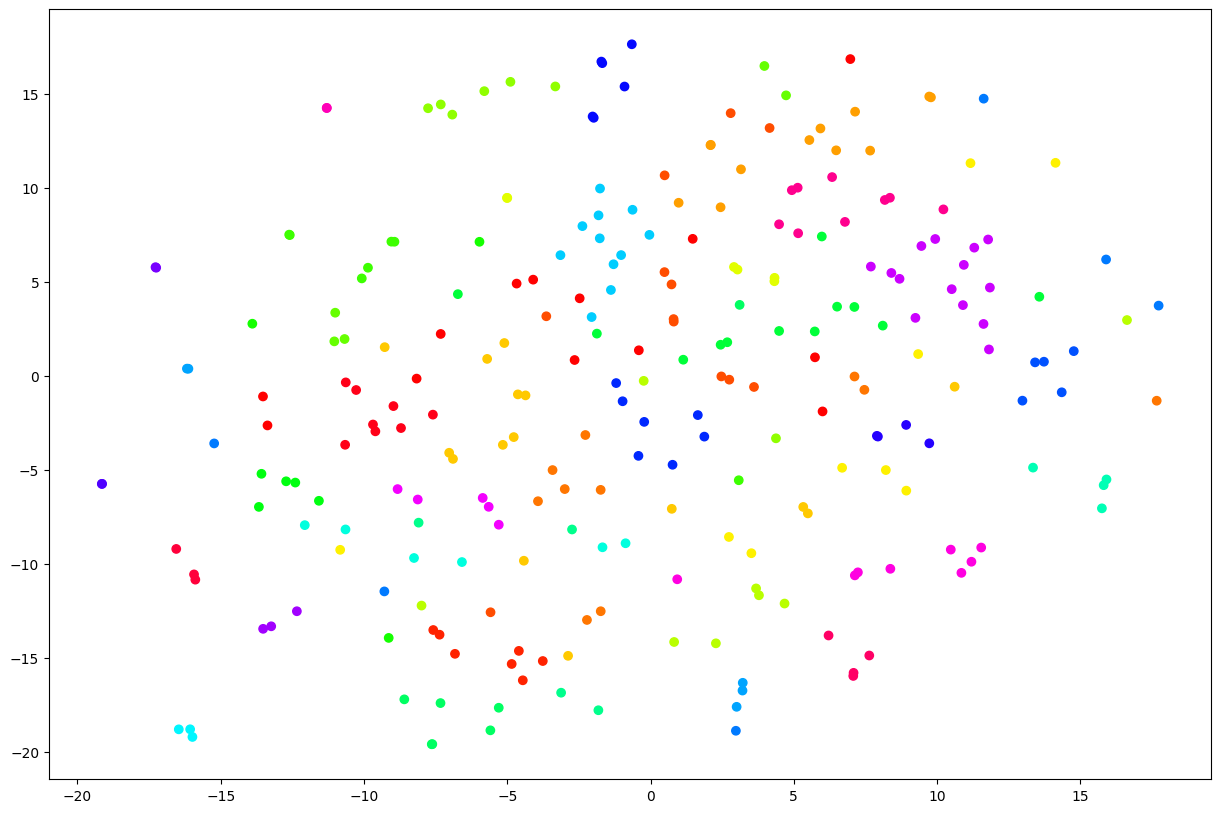

In [20]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15,10))
x = mapped_embeddings[:,0]
y = mapped_embeddings[:,1]
ax.scatter(x, y, c = clusters, cmap = 'hsv')
# ax.legend(clusters, title='clusters')
plt.show()

In [21]:
# present the distribution of clusters: number of recommendations in each cluster
display(pd.DataFrame({'cluster': [i for (i,j) in Counter(clusters).most_common()], 'freq': [j for (i,j) in Counter(clusters).most_common()]}))

,cluster,freq
0,5,15
1,30,14
2,0,13
3,14,12
4,2,12
5,4,12
6,20,11
7,3,10
8,34,9
9,6,9


In [22]:
# create the output table with 3 columns: recommendation text, clusters and years
recommd_cluster = pd.DataFrame({"text": RecommendLists, "cluster": clusters, 'Years': Years})
display(recommd_cluster.loc[recommd_cluster['cluster'] == 5])

,text,cluster,Years
20,5. increase outreach programs to veterans in g...,5,1997
24,9. establish a demonstration project that allo...,5,1997
32,17. initiate an experimental program that allo...,5,1997
41,"26. give priority to awareness, education and ...",5,1997
75,"61. support through funding, the little hoop l...",5,1997
78,1. initiate a review of the funding and operat...,5,1998
79,2. retain in patient ptsd and substance abuse ...,5,1998
126,3. recommends the under secretary for health i...,5,2002
132,recommendation 1 strongly advise establishing ...,5,2004
133,recommendation 2 recommend that visn 20 and th...,5,2004


In [23]:
# save recommd_cluster
with open('recommendation_clusters', 'wb') as fp:
    pickle.dump(recommd_cluster, fp)
# with open('/dbfs/NAII/CMV Reports/recommendation_clusters', 'rb') as fp:
#     recommd_cluster = pickle.load(fp)

In [24]:
import plotly.express as px

recommd_cluster['cluster'] = recommd_cluster['cluster'].astype(str)
fig = px.scatter(recommd_cluster, y="Years", x="cluster", color="cluster")

fig.show()

Generate recommendation summary text for each cluster

In [25]:
# first concatenate all the text strings from the same cluster
dfCluster = recommd_cluster[['cluster', 'text']].groupby('cluster')['text'].apply(' '.join).reset_index()

In [35]:
# use Bart large cnn model for text summarization
import os
import sys
import certifi
import torch
import tensorflow_hub as hub
import os

os.environ['REQUESTS_CA_BUNDLE'] = os.path.join(os.path.dirname(sys.argv[0]), certifi.where())

bart = torch.hub.load('pytorch/fairseq', 'bart.large.cnn')
def allsummary(body):
    summarystr = str(bart.sample(body, beam=4, lenpen=2.0, max_len_b=240, min_len=100, no_repeat_ngram_size=5))
    return summarystr

dfCluster['summarytxt'] = dfCluster.text.apply(allsummary)
display(dfCluster)

Using cache found in c:\users\vacofredrd.upm.temp/.cache\torch\hub\pytorch_fairseq_main
2023-03-29 14:42:30 | INFO | fairseq.file_utils | loading archive file http://dl.fbaipublicfiles.com/fairseq/models/bart.large.cnn.tar.gz from cache at c:\users\vacofredrd.upm.temp\.cache\torch\pytorch_fairseq\6ee6af21df382be253b815b53834cd71f61b7ebb83deaa2d10c5d3f94db833cb.3a612b08cd8ff157daf01330f2160f0889831fcb543ec25aa63e38c726167380


Unable to build Cython components. Please make sure Cython is installed if the torch.hub model you are loading depends on it.


2023-03-29 14:42:36 | INFO | fairseq.tasks.translation | [source] dictionary: 50264 types
2023-03-29 14:42:36 | INFO | fairseq.tasks.translation | [target] dictionary: 50264 types


In [ ]:
# write to csv
recommd_cluster.to_csv('CMV_Reports_Article_Recommendations_df.csv')
dfCluster.to_csv('CMV_Reports_Article_Recommendations_dfCluster.csv')

NameError: name 'recommd_cluster' is not defined